In [1]:
import pandas as pd
from sqlalchemy import create_engine
from config import password
import numpy as np
import matplotlib.pyplot as plt


# Import Data

In [2]:
csv_path = "../perth_market.csv"
perth_df = pd.read_csv(csv_path)
perth_df.head(2)

,ADDRESS,SUBURB,PRICE,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN,NEAREST_STN_DIST,DATE_SOLD,POSTCODE,LATITUDE,LONGITUDE,NEAREST_SCH,NEAREST_SCH_DIST,NEAREST_SCH_RANK
0,1 Acorn Place,South Lake,565000,4,2,2.0,600,160,2003.0,18300,Cockburn Central Station,1800,09-2018\r,6164,-32.11590,115.842450,LAKELAND SENIOR HIGH SCHOOL,0.828339,NaN
1,1 Addis Way,Wandi,365000,3,2,2.0,351,139,2013.0,26900,Kwinana Station,4900,02-2019\r,6167,-32.19347,115.859553,ATWELL COLLEGE,5.524324,129.0


In [3]:
# Removing unwanted columns
cleaned_perth_df = perth_df.drop(columns = ["BATHROOMS","GARAGE","FLOOR_AREA","NEAREST_STN","POSTCODE",
"NEAREST_SCH", "NEAREST_SCH_RANK"])

cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33656 entries, 0 to 33655
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33656 non-null  object 
 1   SUBURB            33656 non-null  object 
 2   PRICE             33656 non-null  int64  
 3   BEDROOMS          33656 non-null  int64  
 4   LAND_AREA         33656 non-null  int64  
 5   BUILD_YEAR        30501 non-null  float64
 6   CBD_DIST          33656 non-null  int64  
 7   NEAREST_STN_DIST  33656 non-null  int64  
 8   DATE_SOLD         33656 non-null  object 
 9   LATITUDE          33656 non-null  float64
 10  LONGITUDE         33656 non-null  float64
 11  NEAREST_SCH_DIST  33656 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 3.1+ MB


In [4]:
# Convert ADDRESS to FULL ADDRESS which includes the Suburb to get unique adress of sold properties
cleaned_perth_df["ADDRESS"] = cleaned_perth_df[["ADDRESS","SUBURB"]].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)

cleaned_perth_df["ADDRESS"]

0              1 Acorn Place, South Lake
1                     1 Addis Way, Wandi
2               1 Ainsley Court, Camillo
3              1 Albert Street, Bellevue
4                1 Aman Place, Lockridge
                      ...               
33651    9C Gold Street, South Fremantle
33652        9C Pycombe Way, Westminster
33653        9D Pycombe Way, Westminster
33654        9D Shalford Way, Girrawheen
33655        9E Margaret Street, Midland
Name: ADDRESS, Length: 33656, dtype: object

In [5]:
# Display duplicate addresses
full_address = cleaned_perth_df["ADDRESS"]
cleaned_perth_df[full_address.isin(full_address[full_address.duplicated()])]

,ADDRESS,SUBURB,PRICE,BEDROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH_DIST
4149,"123 Fairway, Crawley",Crawley,818000,4,160,NaN,5500,3700,02-2018\r,-31.985151,115.815463,3.065177
4150,"123 Fairway, Crawley",Crawley,818000,4,160,NaN,5500,3700,02-2018\r,-31.985152,115.815314,3.059929
4151,"123 Fairway, Crawley",Crawley,818000,4,160,NaN,5500,3700,02-2018\r,-31.985133,115.815176,3.053099
20655,"4 Carmel Road, Carmel",Carmel,955000,4,15761,2009.0,21700,9300,09-2013\r,-32.019395,116.074759,1.890651
20656,"4 Carmel Road, Carmel",Carmel,955000,4,15761,2009.0,21700,9300,09-2013\r,-32.019657,116.096652,0.600853


In [6]:
# Drop duplicate dwelling data
cleaned_perth_df.drop_duplicates(subset=["ADDRESS"], keep="last", inplace=True)
cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33653 entries, 0 to 33655
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           33653 non-null  object 
 1   SUBURB            33653 non-null  object 
 2   PRICE             33653 non-null  int64  
 3   BEDROOMS          33653 non-null  int64  
 4   LAND_AREA         33653 non-null  int64  
 5   BUILD_YEAR        30500 non-null  float64
 6   CBD_DIST          33653 non-null  int64  
 7   NEAREST_STN_DIST  33653 non-null  int64  
 8   DATE_SOLD         33653 non-null  object 
 9   LATITUDE          33653 non-null  float64
 10  LONGITUDE         33653 non-null  float64
 11  NEAREST_SCH_DIST  33653 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 3.3+ MB


In [7]:
# Removing properties with land areas over 2500 sqm
cleaned_perth_df = cleaned_perth_df.loc[cleaned_perth_df["LAND_AREA"]<2500]
cleaned_perth_df

,ADDRESS,SUBURB,PRICE,BEDROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH_DIST
0,"1 Acorn Place, South Lake",South Lake,565000,4,600,2003.0,18300,1800,09-2018\r,-32.115900,115.842450,0.828339
1,"1 Addis Way, Wandi",Wandi,365000,3,351,2013.0,26900,4900,02-2019\r,-32.193470,115.859553,5.524324
2,"1 Ainsley Court, Camillo",Camillo,287000,3,719,1979.0,22600,1900,06-2015\r,-32.120578,115.993579,1.649178
3,"1 Albert Street, Bellevue",Bellevue,255000,2,651,1953.0,17900,3600,07-2018\r,-31.900547,116.038009,1.571401
4,"1 Aman Place, Lockridge",Lockridge,325000,4,466,1998.0,11200,2000,11-2016\r,-31.885790,115.947780,1.514922
...,...,...,...,...,...,...,...,...,...,...,...,...
33651,"9C Gold Street, South Fremantle",South Fremantle,1040000,4,292,2013.0,16100,1500,03-2016\r,-32.064580,115.751820,1.430350
33652,"9C Pycombe Way, Westminster",Westminster,410000,3,228,NaN,9600,4600,02-2017\r,-31.867055,115.841403,1.679644
33653,"9D Pycombe Way, Westminster",Westminster,427000,3,261,NaN,9600,4600,02-2017\r,-31.866890,115.841418,1.669159
33654,"9D Shalford Way, Girrawheen",Girrawheen,295000,3,457,1974.0,12600,4400,10-2016\r,-31.839680,115.842410,0.358494


In [57]:
# Split DATE_SOLD data from MM-YYYY to only get the year part
date_splited = cleaned_perth_df["DATE_SOLD"].str.rsplit('-')

year = []
for date in date_splited:
    year.append(date[1])

cleaned_perth_df["YEAR_SOLD"] = year
cleaned_perth_df["YEAR_SOLD"] = cleaned_perth_df["YEAR_SOLD"].astype(int)
cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30464 entries, 0 to 33655
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           30464 non-null  object 
 1   SUBURB            30464 non-null  object 
 2   PRICE             30464 non-null  int64  
 3   BEDROOMS          30464 non-null  int64  
 4   LAND_AREA         30464 non-null  int64  
 5   BUILD_YEAR        27720 non-null  float64
 6   CBD_DIST          30464 non-null  int64  
 7   NEAREST_STN_DIST  30464 non-null  int64  
 8   DATE_SOLD         30464 non-null  object 
 9   LATITUDE          30464 non-null  float64
 10  LONGITUDE         30464 non-null  float64
 11  NEAREST_SCH_DIST  30464 non-null  float64
 12  YEAR_SOLD         30464 non-null  int32  
dtypes: float64(4), int32(1), int64(5), object(3)
memory usage: 3.1+ MB


In [58]:
# Removing properties which were sold before 2005
cleaned_perth_df = cleaned_perth_df.loc[cleaned_perth_df["YEAR_SOLD"]>=2005]
cleaned_perth_df

,ADDRESS,SUBURB,PRICE,BEDROOMS,LAND_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,YEAR_SOLD
0,"1 Acorn Place, South Lake",South Lake,565000,4,600,2003.0,18300,1800,09-2018\r,-32.115900,115.842450,0.828339,2018
1,"1 Addis Way, Wandi",Wandi,365000,3,351,2013.0,26900,4900,02-2019\r,-32.193470,115.859553,5.524324,2019
2,"1 Ainsley Court, Camillo",Camillo,287000,3,719,1979.0,22600,1900,06-2015\r,-32.120578,115.993579,1.649178,2015
3,"1 Albert Street, Bellevue",Bellevue,255000,2,651,1953.0,17900,3600,07-2018\r,-31.900547,116.038009,1.571401,2018
4,"1 Aman Place, Lockridge",Lockridge,325000,4,466,1998.0,11200,2000,11-2016\r,-31.885790,115.947780,1.514922,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33651,"9C Gold Street, South Fremantle",South Fremantle,1040000,4,292,2013.0,16100,1500,03-2016\r,-32.064580,115.751820,1.430350,2016
33652,"9C Pycombe Way, Westminster",Westminster,410000,3,228,NaN,9600,4600,02-2017\r,-31.867055,115.841403,1.679644,2017
33653,"9D Pycombe Way, Westminster",Westminster,427000,3,261,NaN,9600,4600,02-2017\r,-31.866890,115.841418,1.669159,2017
33654,"9D Shalford Way, Girrawheen",Girrawheen,295000,3,457,1974.0,12600,4400,10-2016\r,-31.839680,115.842410,0.358494,2016


In [60]:
cleaned_perth_df.to_csv("csv/perth_properties.csv", index=False)

In [10]:
# Create csv files for SQL databases
address_suburb_df = cleaned_perth_df[["ADDRESS","SUBURB"]]
address_suburb_df.to_csv("csv/address_suburb.csv", index=False)

address_price_df = cleaned_perth_df[["ADDRESS","PRICE"]]
address_price_df.to_csv("csv/address_price.csv", index=False)


C:\Users\Nassim\anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([2.0000e+00, 3.0000e+00, 9.0000e+00, 5.0000e+00, 2.6000e+01,
        8.1000e+01, 2.1500e+02, 7.1000e+02, 3.9390e+03, 1.0974e+04]),
 array([1989. , 1992.1, 1995.2, 1998.3, 2001.4, 2004.5, 2007.6, 2010.7,
        2013.8, 2016.9, 2020. ]),
 <BarContainer object of 10 artists>)

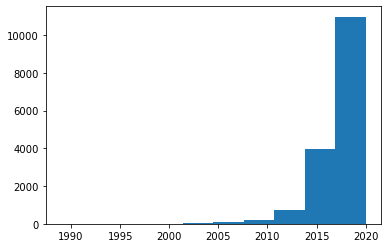

In [46]:
bedroom_df = cleaned_perth_df.loc[cleaned_perth_df["BEDROOMS"]== 4]
bedroom_df["YEAR_SOLD"] = bedroom_df["YEAR_SOLD"].astype(int)
# bedroom_df["YEAR_SOLD"].hist(bins = 1, range=[2000, 2010], grid=False)
plt.hist(bedroom_df["YEAR_SOLD"])

<AxesSubplot:>

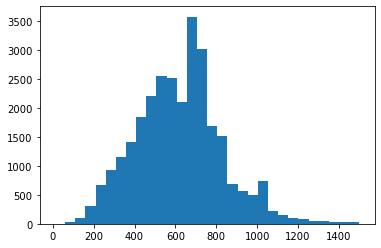

In [11]:
cleaned_perth_df["LAND_AREA"].hist(bins = 30, range=[10, 1500], grid=False)


In [47]:
cleaned_perth_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30464 entries, 0 to 33655
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ADDRESS           30464 non-null  object 
 1   SUBURB            30464 non-null  object 
 2   PRICE             30464 non-null  int64  
 3   BEDROOMS          30464 non-null  int64  
 4   LAND_AREA         30464 non-null  int64  
 5   BUILD_YEAR        27720 non-null  float64
 6   CBD_DIST          30464 non-null  int64  
 7   NEAREST_STN_DIST  30464 non-null  int64  
 8   DATE_SOLD         30464 non-null  object 
 9   LATITUDE          30464 non-null  float64
 10  LONGITUDE         30464 non-null  float64
 11  NEAREST_SCH_DIST  30464 non-null  float64
 12  YEAR_SOLD         30464 non-null  object 
dtypes: float64(4), int64(5), object(4)
memory usage: 3.3+ MB


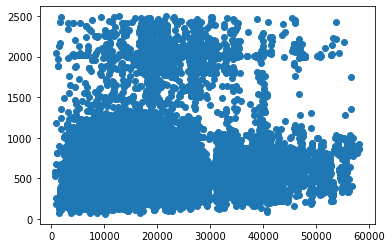

In [50]:
plt.scatter(cleaned_perth_df["CBD_DIST"], cleaned_perth_df["LAND_AREA"])